# Image Classification Overview
- Load data
- Visualize data
- Create dataset
- Convolutional neural net
- Train
- Prediction
- Transfer learning

## 72% accuracy jumps to 78% accuracy, the results can be improved by using data augmentations and better network structure, but here is just a very simple coding practice.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


## Load data

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
template1 = 'train images: {}, train labels: {}'
template2 = 'test images: {}, test labels: {}'
print(template1.format(train_images.shape, train_labels.shape))
print(template2.format(test_images.shape, test_labels.shape))

train images: (50000, 32, 32, 3), train labels: (50000, 1)
test images: (10000, 32, 32, 3), test labels: (10000, 1)


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
idx_cat = {k: v for k, v in enumerate(class_names)}
print(idx_cat)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


## Visualize data

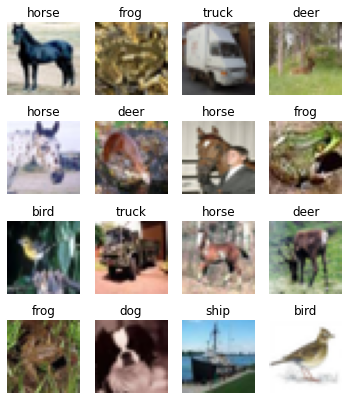

In [ ]:
samples = np.random.choice(train_images.shape[0], size=16)
plt.figure(figsize=(6, 7))
for i, n in enumerate(samples):
  plt.subplot(4, 4, i+1)
  plt.imshow(train_images[n])
  plt.title(idx_cat[train_labels[n][0]])
  plt.axis('off')
plt.show()

## Create dataset

In [ ]:
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))\
.shuffle(10000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))\
.batch(BATCH_SIZE)

## Convolutional neural network

In [ ]:
with strategy.scope():
  cnn = models.Sequential()
  cnn.add(layers.Input(shape=(train_images.shape[1:])))
  cnn.add(layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'))
  # cnn.add(layers.experimental.preprocessing.RandomRotation(0.05))
  cnn.add(layers.experimental.preprocessing.Rescaling(1./255))
  cnn.add(layers.Conv2D(32, 3, 1, 'valid'))
  cnn.add(layers.LeakyReLU())
  cnn.add(layers.MaxPool2D(2, 2))
  #
  cnn.add(layers.Conv2D(64, 3, 1, 'valid'))
  cnn.add(layers.LeakyReLU())
  cnn.add(layers.MaxPool2D(2, 2))
  #
  cnn.add(layers.Conv2D(128, 3, 1, 'valid'))
  cnn.add(layers.LeakyReLU())
  cnn.add(layers.MaxPool2D(2, 2))
  #
  cnn.add(layers.Flatten())
  cnn.add(layers.Dense(64))
  cnn.add(layers.LeakyReLU())
  cnn.add(layers.Dense(64))
  cnn.add(layers.LeakyReLU())
  cnn.add(layers.Dense(10, activation='softmax'))

  cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])
print(f'Parameters: {cnn.count_params()}')

Parameters: 130890


## Train

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
cnn.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[es])

## Prediction

In [73]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

accuracy: 0.7264


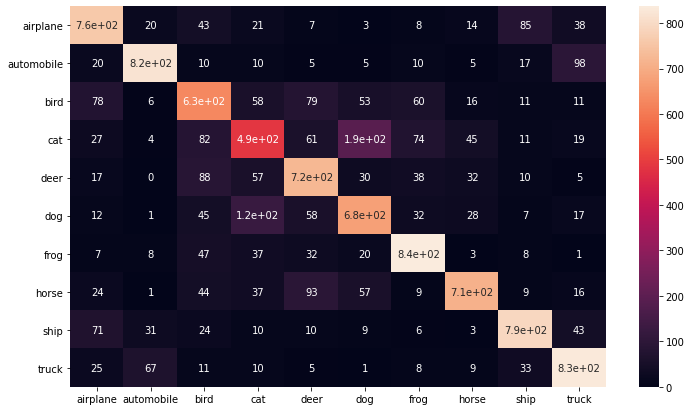

In [81]:
y_hat = cnn.predict(test_ds).argmax(axis=1)
y = test_labels
print(f'accuracy: {np.mean(y.squeeze()==y_hat)}')
plt.figure(figsize=(12, 7))
sns.heatmap(confusion_matrix(y, y_hat), annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

## Transfer Learning

In [ ]:
with strategy.scope():
  base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(128, 128, 3))
  base_model.trainable = False
  base_model.output
  model = models.Sequential()
  model.add(layers.Input(shape=(train_images.shape[1:])))
  model.add(layers.experimental.preprocessing.Resizing(128, 128))
  model.add(base_model)
  model.add(layers.AveragePooling2D(4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
# print(f'Parameters: {model.count_params()}')

In [72]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[es])

accuracy: 0.7824


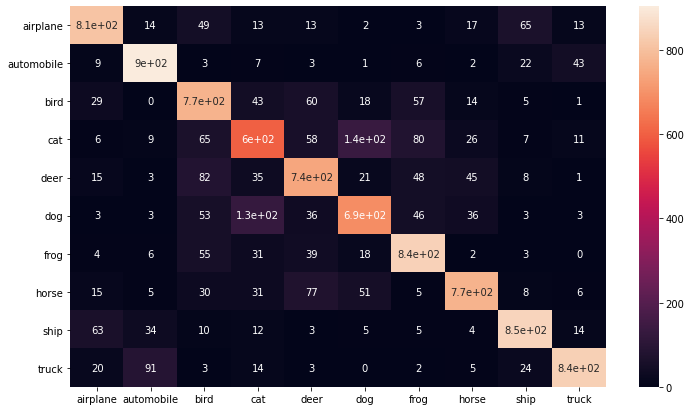

In [82]:
y_hat = model.predict(test_ds).argmax(axis=1)
y = test_labels
print(f'accuracy: {np.mean(y.squeeze()==y_hat)}')
plt.figure(figsize=(12, 7))
sns.heatmap(confusion_matrix(y, y_hat), annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

# 72% accuracy jumps to 78% accuracy